Run this command for starting the container:

`docker run -p 8888:8888 -p 6006:6006 -it -u user -w /home/user tiagopeixoto/graph-tool bash`

Then run the following to start the notebook (once the container has started):

`jupyter notebook --ip 0.0.0.0`

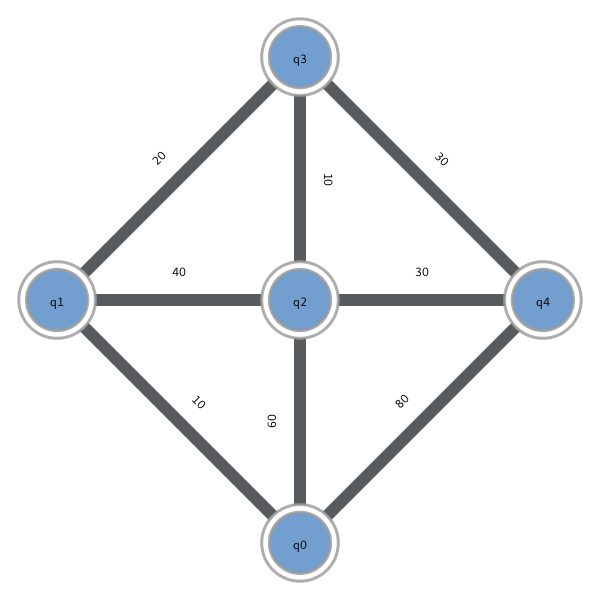

Position vertex #4:  [ 5.  3.]
Edge 0-4: (0, 4)
Weight edge 0-4:  80
Distance 0-4: 2.8284271247461903
Vertices:  [0 1 2 3 4]
Edges:  [[0 1 0]
 [0 2 1]
 [0 4 2]
 [1 2 3]
 [1 3 4]
 [2 4 5]
 [3 2 6]
 [4 3 7]]
List of positions:  [[3.0, 5.0], [1.0, 3.0], [3.0, 3.0], [3.0, 1.0], [5.0, 3.0]]
List of weights:  [10.0, 60.0, 80.0, 40.0, 20.0, 30.0, 10.0, 30.0]


In [39]:
from math import sqrt

from graph_tool.all import *

# Load the graph
g = load_graph("/tmp/assets/cities_example.xml")

# Put the properties in vars
name = g.vp["name"]
weight = g.ep["weight"]
pos = g.vp["pos"]
graph_draw(
    g, pos, vertex_text=name, vertex_font_size=12, 
    vertex_shape="double_circle", vertex_fill_color="#729fcf", 
    vertex_pen_width=3, edge_pen_width=12, edge_text=weight, 
    output="search_cities.pdf",
)

# Accessing the graph members
print("Position vertex #4: ", pos[g.vertex(4)].a)
print("Edge 0-4:", g.edge(0, 4))
print("Weight edge 0-4: ", weight[g.edge(0, 4)])
print("Distance 0-4:", sqrt(sum((pos[g.vertex(0)].a - pos[g.vertex(4)].a) ** 2)))
print("Vertices: ", g.get_vertices())
print("Edges: ", g.get_edges())
print("List of positions: ", [list(pos[v].a) for v in g.get_vertices()])
print("List of weights: ",[float(weight[e]) for e in g.get_edges()])



In [40]:
class BFS(BFSVisitor):
    """Extend Breadth First Search in order to explain the internals"""
    
    def __init__(self, name, pred, dist):
        """
        Initialize the instance
        :param name: Name of the graph
        :param pred: Predecessor tree
        :param dist: Distances tree
        """
        self.name = name
        self.pred = pred
        self.dist = dist

    def discover_vertex(self, u):
        """This is invoked when a vertex is encountered for the first time."""
        print("-->", self.name[u], "has been discovered!")

    def examine_vertex(self, u):
        """
        This is invoked on every out-edge of each vertex after it is discovered
        """
        print(self.name[u], "has been examined")

    def tree_edge(self, e):
        """
        This is invoked on each edge as it becomes a member of the edges 
        that form the search tree.
        """
        print("Adding edge: ", e)
        self.pred[e.target()] = int(e.source())
        self.dist[e.target()] = self.dist[e.source()] + 1


dist = g.new_vertex_property("int")
pred = g.new_vertex_property("int64_t")

# Invoke the search
bfs_search(g, g.vertex(0), BFS(name, pred, dist))

print(dist.a)
print(pred.a)

--> q0 has been discovered!
q0 has been examined
Adding edge:  (0, 1)
--> q1 has been discovered!
Adding edge:  (0, 2)
--> q2 has been discovered!
Adding edge:  (0, 4)
--> q4 has been discovered!
q1 has been examined
Adding edge:  (1, 3)
--> q3 has been discovered!
q2 has been examined
q4 has been examined
q3 has been examined
[0 1 1 2 1]
[0 0 0 1 0]


In this example we'll use A* for getting a solution for the previous graph.

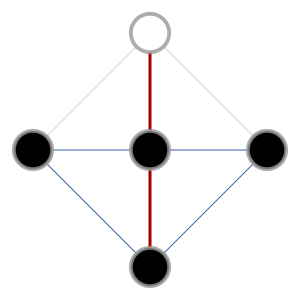

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f53a2598978, at 0x7f53a2598c88>

In [41]:
import matplotlib

BLUE = "#3465a4"
GREY = "#d3d7cf"
RED = "#a40000"

# Edge width for a solution path
PATH_WIDTH = 3
REGULAR_WIDTH = 1


def h(v, target, pos):
    """Heuristic function that calculates the Euclidean distance"""
    return sqrt(sum((pos[v].a - pos[target].a) ** 2))


class VisitorExample(AStarVisitor):

    def __init__(self, touched_v, touched_e, target):
        self.touched_v = touched_v
        self.touched_e = touched_e
        self.target = target

    def discover_vertex(self, u):
        self.touched_v[u] = True

    def examine_edge(self, e):
        self.touched_e[e] = True

    def edge_relaxed(self, e):
        if e.target() == self.target:
            raise StopSearch()


weight = g.new_edge_property("double")

touch_v = g.new_vertex_property("bool")
touch_e = g.new_edge_property("bool")
target = g.vertex(3)
dist, pred = astar_search(
    g, 
    source=g.vertex(0), 
    weight=weight,
    visitor=VisitorExample(touch_v, touch_e, target),
    heuristic=lambda v: h(v, target, pos)
)
ecolor = g.new_edge_property("string")
ewidth = g.new_edge_property("double")
ewidth.a = REGULAR_WIDTH
for e in g.edges():
    ecolor[e] = BLUE if touch_e[e] else GREY
v = target
while v != g.vertex(0):
    p = g.vertex(pred[v])
    for e in v.out_edges():
        if e.target() == p:
            ecolor[e] = RED
            ewidth[e] = PATH_WIDTH
    v = p

# Represent the graph
graph_draw(g, pos=pos, output_size=(300, 300), vertex_fill_color=touch_v, 
           vcmap=matplotlib.cm.binary, edge_color=ecolor,
           edge_pen_width=ewidth, output="astar-cities.pdf")

In this example we'll load a more complex graph representing a map with some Romanian cities.
We'll use the same heuristic function and class from the previous example so that we need to run it before we get valid results.

We are traveling from Arad to Bucharest

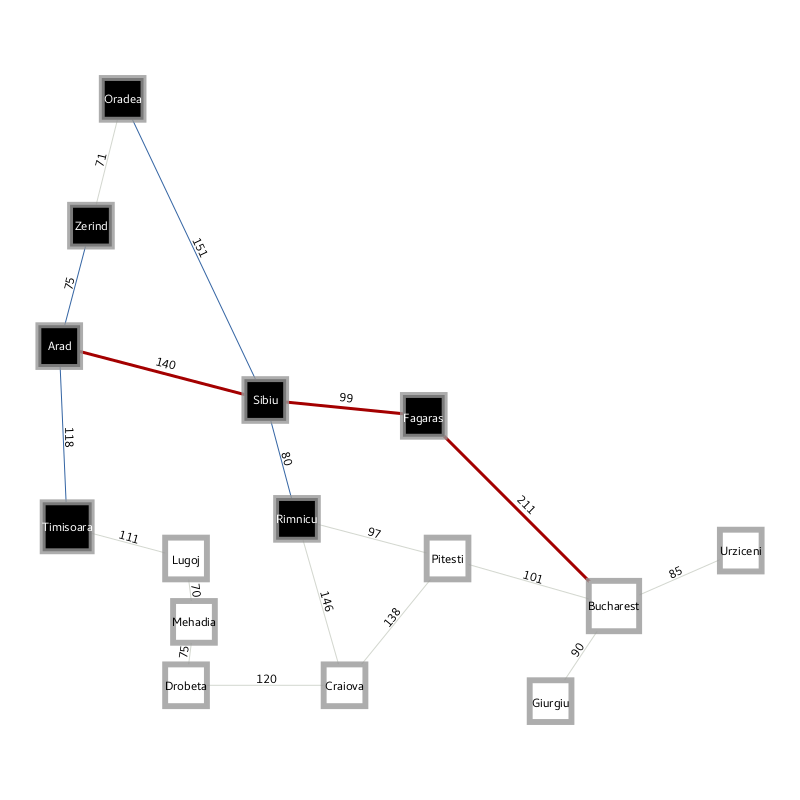

A* says a good distance to Bucharest is  450


In [43]:
g = load_graph("/tmp/assets/romania.xml")

ARAD = 0
BUCHAREST = 13

# Put the properties in vars
name = g.vp["name"]
weight = g.ep["weight"]
pos = g.vp["pos"]

touch_v = g.new_vertex_property("bool")
touch_e = g.new_edge_property("bool")

# Destination: Bucharest
target = g.vertex(BUCHAREST)

# Run the algorithm
# returns: 
#  * dist: A vertex property map with the computed distances from the source.
#  * pred: A vertex property map with the predecessor tree.
dist, pred = astar_search(
    g, 
    source=g.vertex(ARAD), 
    weight=weight,
    visitor=VisitorExample(touch_v, touch_e, target),
    heuristic=lambda v: h(v, target, pos)
)

ecolor = g.new_edge_property("string")
ewidth = g.new_edge_property("double")
ewidth.a = REGULAR_WIDTH

# Assign colors to the edges
for e in g.edges():
    ecolor[e] = BLUE if touch_e[e] else GREY

# Assign colors to the vertices
v = target
while v != g.vertex(0):
    p = g.vertex(pred[v])
    for e in v.out_edges():
        if e.target() == p:
            ecolor[e] = RED
            ewidth[e] = PATH_WIDTH
    v = p

# Finally we'll draw the graph representing the map and the solution.
# We'll use black color for the estimated vertices, blue for the dismissed edges and 
# red the proposed solution.

graph_draw(g, pos=pos, output_size=(800, 800), vertex_fill_color=touch_v,
           vertex_shape='square', vertex_text=name, vcmap=matplotlib.cm.binary, edge_color=ecolor,
           edge_pen_width=ewidth, edge_text=weight, output="astar-romanian-cities.pdf")

print("A* says a good distance to Bucharest is ", dist.a[BUCHAREST])

In the next version, we'll use Dijkstra for getting the optimun solution.

In [ ]:
class VisitorExample(DijkstraVisitor):

    def __init__(self, name, time):
        self.name = name
        self.time = time
        self.last_time = 0

    def discover_vertex(self, u):
        print("-->", self.name[u], "has been discovered!")
        self.time[u] = self.last_time
        self.last_time += 1

    def examine_edge(self, e):
        print(
            "edge (%s, %s) has been examined..." %
            (self.name[e.source()], self.name[e.target()]),
        )

    def edge_relaxed(self, e):
        print(
            "edge (%s, %s) has been relaxed..." %
            (self.name[e.source()], self.name[e.target()]),
        )


time = g.new_vertex_property("int")
dist, pred = dijkstra_search(g, weight, g.vertex(0), VisitorExample(name, time))
# Print the results
print(time.a)
print(pred.a)
print(dist.a)

print("Dijktra says the shortest distance to Bucharest is ", dist.a[BUCHAREST])

--> Arad has been discovered!
edge (Arad, Zerind) has been examined...
edge (Arad, Zerind) has been relaxed...
--> Zerind has been discovered!
edge (Arad, Timisoara) has been examined...
edge (Arad, Timisoara) has been relaxed...
--> Timisoara has been discovered!
edge (Arad, Sibiu) has been examined...
edge (Arad, Sibiu) has been relaxed...
--> Sibiu has been discovered!
edge (Zerind, Oradea) has been examined...
edge (Zerind, Oradea) has been relaxed...
--> Oradea has been discovered!
edge (Zerind, Arad) has been examined...
edge (Timisoara, Lugoj) has been examined...
edge (Timisoara, Lugoj) has been relaxed...
--> Lugoj has been discovered!
edge (Timisoara, Arad) has been examined...
edge (Sibiu, Rimnicu) has been examined...
edge (Sibiu, Rimnicu) has been relaxed...
--> Rimnicu has been discovered!
edge (Sibiu, Fagaras) has been examined...
edge (Sibiu, Fagaras) has been relaxed...
--> Fagaras has been discovered!
edge (Sibiu, Arad) has been examined...
edge (Sibiu, Oradea) has be